In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import minimize, rosen, rosen_der, fsolve, broyden1
from scipy.optimize.nonlin import BroydenFirst, KrylovJacobian
import math
import numpy.linalg as LA
import sympy as sp
import scipy.optimize
import random

In [2]:
#Задаём константы
tol = 0.00001

la = 13. # l у основания
lb = 13. # l у основания
lc = 4.25 #L
ld = 4.25 #L
l = la # l у основания
L = lc #L
d = 12.

f1 = 0.
f2 = 0.
work_space = []

In [3]:
x, y, t1, t2, f1, f2, l, L, d = sp.symbols('x y t1 t2 f1 f2 l L d')
la = 13. # l у основания
lb = 13. # l у основания
lc = 4.25 #L
ld = 4.25 #L
l = la # l у основания
L = lc #L
d = 12.
diff_symb = [x, y, t1, t2, f1, f2]
out_and_pass = [x, y, f1, f2]
in_and_pass = [t1, t2, f1, f2]
func1 = sp.Function('func1')
func2 = sp.Function('func2')
func3 = sp.Function('func3')
func4 = sp.Function('func4')

In [4]:
func1 = x-l*sp.cos(t1)-L*sp.cos(f1)
func2 = x-l*sp.cos(t2)-L*sp.cos(f2)-d
func3 = y-l*sp.sin(t1)-L*sp.sin(f1)
func4 = y-l*sp.sin(t2)-L*sp.sin(f2)
F = [func1, func2, func3, func4]

In [5]:
J_out_and_pass = sp.zeros(len(F),len(out_and_pass))
i=0
j=0
while i < len(F):
    j=0
    while j < len(out_and_pass):
        J_out_and_pass[i,j] = sp.diff(F[i], out_and_pass[j])
        j+=1
    i+=1
J_out_and_pass

Matrix([
[1, 0,  4.25*sin(f1),             0],
[1, 0,             0,  4.25*sin(f2)],
[0, 1, -4.25*cos(f1),             0],
[0, 1,             0, -4.25*cos(f2)]])

In [6]:
J_in_and_pass = sp.zeros(len(F),len(in_and_pass))
i=0
j=0
while i < len(F):
    j=0
    while j < len(in_and_pass):
        J_in_and_pass[i,j] = sp.diff(F[i], in_and_pass[j])
        j+=1
    i+=1
J_in_and_pass

Matrix([
[ 13.0*sin(t1),             0,  4.25*sin(f1),             0],
[            0,  13.0*sin(t2),             0,  4.25*sin(f2)],
[-13.0*cos(t1),             0, -4.25*cos(f1),             0],
[            0, -13.0*cos(t2),             0, -4.25*cos(f2)]])

In [7]:
sp.simplify(J_out_and_pass.det())

-18.0625*sin(f1 - f2)

In [8]:
sp.simplify(J_in_and_pass.det())

3052.5625*sin(f1 - t1)*sin(f2 - t2)

In [9]:
symp_sing1 = sp.simplify(J_in_and_pass.det())
const1 = symp_sing1.func(*[term for term in symp_sing1.args if not term.free_symbols])
symp_sing1 = symp_sing1/const1
sing_f_1 = sp.lambdify(diff_symb, symp_sing1, 'numpy')

symp_sing2 = sp.simplify(J_out_and_pass.det())
const2 = symp_sing2.func(*[term for term in symp_sing2.args if not term.free_symbols])
symp_sing2 = symp_sing2/const2
sing_f_2 = sp.lambdify(diff_symb, symp_sing2, 'numpy')

In [10]:
min_val, max_val = -16, 16
v1 = np.linspace(min_val, max_val, int((max_val-min_val)/4)+1)

appr = []

for i in v1:
    for j in v1:
        for k in v1:
            for o in v1:
                for m in v1:
                    for p in v1:  
                        appr.append([i,j,k,o,m,p])

In [11]:
appr[1]

[-16.0, -16.0, -16.0, -16.0, -16.0, -12.0]

In [12]:
def is_inside(x, y, d):
    D1=(2 * (-1*(x)/(y)) * ( (x)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) ))**2 - 4*(1 + ((x)**2)/(y**2) ) * ( ( (x)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) )**2 - la**2) 
    D2=(2 * (-1*(x-d)/(y)) * ( (x-d)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) ))**2 - 4*(1 + ((x-d)**2)/(y**2) ) * ( ( (x-d)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) )**2 - la**2)     
    if D1 >= 0 and D2 >= 0:
        work_space.append([x,y])
        return 1
    return 0

In [13]:
def kinematic_eq_sing1(z):
    x = z[0]
    y = z[1]
    t1 = z[2]
    t2 = z[3]
    f1 = z[4]
    f2 = z[5]

    F = np.zeros(6)
    F[0] = (x-l*np.cos(t1)-L*np.cos(f1))
    F[1] = (x-l*np.cos(t2)-L*np.cos(f2)-d)
    F[2] = (y-l*np.sin(t1)-L*np.sin(f1))
    F[3] = (y-l*np.sin(t2)-L*np.sin(f2))
    F[4] = sing_f_1(x,y,t1,t2,f1,f2)
    return F

def kinematic_eq_sing2(z):
    x = z[0]
    y = z[1]
    t1 = z[2]
    t2 = z[3]
    f1 = z[4]
    f2 = z[5]

    F = np.zeros(6)
    F[0] = (x-l*np.cos(t1)-L*np.cos(f1))
    F[1] = (x-l*np.cos(t2)-L*np.cos(f2)-d)
    F[2] = (y-l*np.sin(t1)-L*np.sin(f1))
    F[3] = (y-l*np.sin(t2)-L*np.sin(f2))
    F[4] = sing_f_2(x,y,t1,t2,f1,f2)
    
    return F

Robot work area:


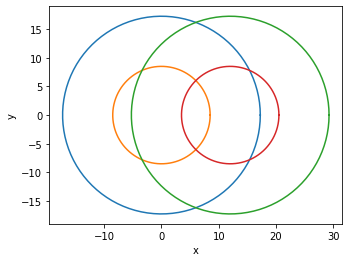

In [14]:
# окружности в питоне легче всего задавать через сферические координаты
# тета меняется от 0 до 2pi
theta = np.linspace(0, 2*np.pi, 100)

x1 = (la+lc)*np.cos(theta)
x2 = (la+lc)*np.sin(theta)
x3 = 2*lc*np.cos(theta)
x4 = 2*lc*np.sin(theta)
x5 = (la+lc)*np.cos(theta)+d
x6 = (la+lc)*np.sin(theta)
x7 = 2*lc*np.cos(theta)+d
x8 = 2*lc*np.sin(theta)

#задаю сетку для расчёта рабочей области
gr_x = np.linspace(-20, 20, 300)
gr_y = np.linspace(-20, 20, 300)
# gr_x = np.linspace(-(la+lc), la+lc+d, 250)
# gr_y = np.linspace(-(la+lc), la+lc+d, 250)
gr_X, gr_Y = np.meshgrid(gr_x,gr_y)
    
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.plot(x3, x4)
ax.plot(x5, x6)
ax.plot(x7, x8)
ax.set_aspect(1)
plt.xlabel('x')
plt.ylabel('y')
print('Robot work area:')
# plt.show()

# plt.scatter(gr_X, gr_Y, color = 'black')
# plt.show()

In [15]:
#функция подсчёта площади
def count_area_new(d_iter):
    S_square=40*40
    number_of_points = len(gr_x)*len(gr_y) #50 000
    number_inside = 0
    for i in range(len(gr_x)):
        for j in range(len(gr_y)):
            number_inside+=is_inside(gr_x[i], gr_y[j], d_iter)
#             is_gran(gr_x[i], gr_y[j], d_iter)
#     S=(S_square*number_inside/number_of_points) # /2 из-за того, что области на графике две, но в реальности она одна
    S = S_square*len(work_space)/number_of_points
    return S

In [16]:
count_area_new(d)

181.79555555555555

Robot work area:


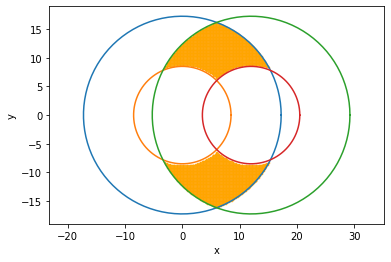

In [17]:
# отрисовка рабочей области
print('Robot work area:')
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.plot(x3, x4)
ax.plot(x5, x6)
ax.plot(x7, x8)
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
# plt.scatter(*zip(*gran), color = 'black')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [18]:
z1 = []
i=0
while i < len(appr):
    zGuess = appr[i]
    x_tmp1 = fsolve(kinematic_eq_sing1, zGuess, xtol=tol)
    f_tmp1 = kinematic_eq_sing1(x_tmp1)
    if np.linalg.norm(np.array(f_tmp1)) < tol:
        z1.append(x_tmp1)
    i+=10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


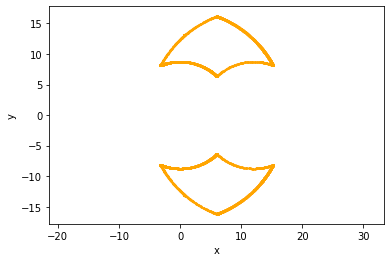

In [19]:
sing_xy1 = []
for i in z1:
    sing_xy1.append([i[0],i[1]])
    
plt.scatter(*zip(*sing_xy1), color = 'orange', s=0.5)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [20]:
z2 = []
i=0
while i < len(appr):
    zGuess = appr[i]
    x_tmp2 = fsolve(kinematic_eq_sing2, zGuess, xtol=tol)
    f_tmp2 = kinematic_eq_sing2(x_tmp2)
    if np.linalg.norm(np.array(f_tmp2)) < tol:
        z2.append(x_tmp2)
    i+=10

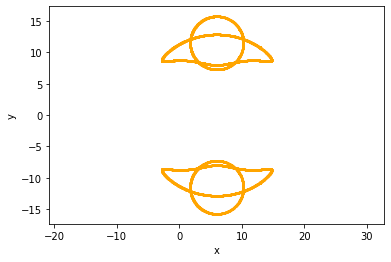

In [21]:
sing_xy2 = []
for i in z2:
    sing_xy2.append([i[0],i[1]])
    
plt.scatter(*zip(*sing_xy2), color = 'orange', s=0.5)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [22]:
xMin = -10
xMax = 20
yMin = -20
yMax = 20
num_squares = 2**16
square_size = abs(xMax-xMin)/np.sqrt(num_squares)
ox = np.linspace(xMin, xMax, np.sqrt(num_squares)+1)
oy = np.linspace(yMin, yMax, np.sqrt(num_squares)+1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [23]:
sing_xy1_sample = random.sample(sing_xy1, int(round(len(sing_xy1)*0.5,0)))
sing_xy2_sample = random.sample(sing_xy2, int(round(len(sing_xy2)*0.5,0)))

In [24]:
sing_squares_sing1 = []
sing_squares_sing2 = []

def get_square(p, sing_set):
    i = 0
    while i < len(ox)-1:
        j = 0
        while j < len(oy)-1:
            if p[0] >= ox[i]:
                if p[0] <= ox[i+1]:
                    if p[1] >= oy[j]:
                        if p[1] <= oy[j+1]:
                            sing_set.append([[ox[i],ox[i+1]],[oy[j],oy[j+1]]])
            j+=1
        i+=1
    return sing_set

for i in sing_xy1_sample:
    get_square(i, sing_squares_sing1)
    
for i in sing_xy2_sample:
    get_square(i, sing_squares_sing2)
    
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

18073
16048


In [25]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

sing_squares_sing1 = Remove(sing_squares_sing1)
sing_squares_sing2 = Remove(sing_squares_sing2)
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

824
1181


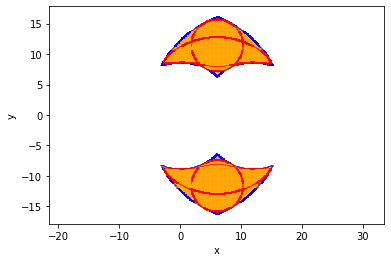

In [26]:
plt.figure()
currentAxis = plt.gca()
for i in sing_squares_sing1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size,alpha=1,color='Blue'))
for i in sing_squares_sing2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size,alpha=1,color='Red'))
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

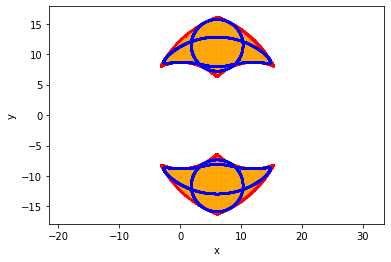

In [27]:
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
plt.scatter(*zip(*sing_xy1), color = 'red', s=0.5)
plt.scatter(*zip(*sing_xy2), color = 'blue', s=0.5)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()